## Code for the paper 'OTCOP: Learning optimal transport maps via constraint optimizations'

In [ ]:
import torch
from torch import nn, optim, autograd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
device = 'cuda' # to train with cpu use device = 'cpu'

Define the Generator and Discriminator network structure

In [ ]:
h_dim = 400
batch_size = 512
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 2),
        )
    def forward(self, z):
        output = self.net(z)
        return output
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.net(x)
        return output.reshape(-1)

In [ ]:
netG = Generator()
netD = Discriminator()
print(netG)
print(netD)

Generator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=400, out_features=2, bias=True)
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=400, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


The base distribution is the standard normal and the target is the Gaussian mixtures, code for generating the target distribution is below

(-3.0, 3.0)

<Figure size 432x288 with 0 Axes>

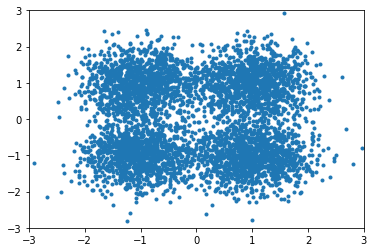

In [ ]:
# generated dataset
base_dist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device),torch.eye(2).to(device))
sig = torch.eye(2)*3 + torch.ones((2,2))

def data_generator():
    # 2-gaussian mxiture models
    base_dist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device),torch.eye(2).to(device))
    n = 4
    import numpy as np 
    x=np.array([[-1,-1],[-1,1],[1,1],[1,-1]]).astype('float')
    x=torch.from_numpy(x)
    import torch.distributions as D
    mix = D.Categorical(torch.ones(n,).to(device))
    comp = D.Independent(D.Normal(
                       x.to(device), (torch.ones(n,2)*0.5).to(device)), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    target_dist = gmm
    sig = torch.eye(2)*3 + torch.ones((2,2))

    target_dist =gmm# torch.distributions.MultivariateNormal(torch.ones(2).to(device),sig.to(device))

    while True:
      dataset = target_dist.sample((512,))
      yield dataset
    # samples = base_dist.sample((60000,))
    # target_dist = torch.distributions.MultivariateNormal(torch.ones(2).to(device),torch.eye(2).to(device))
    # samples = target_dist.sample((60000,))


    # """
    # 8-gaussian mixture models
    # :return:
    # """
    # scale = 2.
    # centers = [
    #     (1, 0),
    #     (-1, 0),
    #     (0, 1),
    #     (0, -1),
    #     (1. / np.sqrt(2), 1. / np.sqrt(2)),
    #     (1. / np.sqrt(2), -1. / np.sqrt(2)),
    #     (-1. / np.sqrt(2), 1. / np.sqrt(2)),
    #     (-1. / np.sqrt(2), -1. / np.sqrt(2)),
    # ]
    # centers = [(scale * x, scale * y) for x, y in centers]
    # while True:
    #     dataset = []
    #     for i in range(batch_size):
    #         point = np.random.randn(2) * 0.02
    #         center = random.choice(centers)
    #         # N(0, 1) + center_x1,x2
    #         point[0] += center[0]
    #         point[1] += center[1]
    #         dataset.append(point)
    #     dataset = np.array(dataset).astype(np.float32)
    #     dataset /= 1.414
    #     yield dataset


n = 4
import numpy as np 
x=np.array([[-1,-1],[-1,1],[1,1],[1,-1]]).astype('float')
x=torch.from_numpy(x)
import torch.distributions as D
mix = D.Categorical(torch.ones(n,).to(device))
comp = D.Independent(D.Normal(
                    x.to(device), (torch.ones(n,2)*0.5).to(device)), 1)
gmm = D.MixtureSameFamily(mix, comp)
target_dist = gmm
sig = torch.eye(2)*3 + torch.ones((2,2))

target_dist =gmm

plt.figure()
Y = target_dist.sample((5000,))
plt.figure()

plt.plot(Y[:,0].detach().cpu().numpy(),Y[:,1].detach().cpu().numpy(),'.')
plt.ylim([-3,3])
plt.xlim([-3,3])


In [ ]:
# Define the gradient penalty
def gradient_penalty(D, xr, xf):
    t = torch.rand(batch_size, 1).cuda()
    t = t.expand_as(xr)
    mid = t * xr + (1 - t) * xf
    mid.requires_grad_()
    pred = D(mid)
    grads = autograd.grad(outputs=pred, inputs=mid,
                          grad_outputs=torch.ones_like(pred),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()
    return gp
wasserstein_loss = nn.MSELoss()

### 1. Train by the WGAN-GP, obtained transport cost around 3.81

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda')
data_iter = data_generator()
clip_value = 0.1
G = Generator().to(device)
D = Discriminator().to(device)

l2loss = nn.MSELoss()
G = Generator().to(device)
D = Discriminator().to(device)
optim_G = optim.Adam(G.parameters(), lr=5e-4, betas=(0.5, 0.9))
optim_D = optim.Adam(D.parameters(), lr=5e-4, betas=(0.5, 0.9))
loss_G = []
w_losses = []
losses_D = []
rho = 1e-4
for epoch in range(2000):
    for _ in range(5): 
        xr = next(data_iter).float()
        predr = D(xr)
        lossr = -predr.mean()
        z = base_dist.sample((batch_size,))
        xf = G(z).detach()  
        predf = D(xf)
        lossf = predf.mean()
        gp = gradient_penalty(D, xr, xf.detach())
        loss_D = lossr + lossf  + 0.2 * gp 
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

    z = torch.randn(batch_size, 2).to(device)
    xf = G(z)
    predf = D(xf)
    loss_G = -predf.mean() 
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
    w_losses.append(l2loss(z,xf).item())
    losses_D.append(torch.abs(loss_D).item())
    if epoch % 100 == 0:
        print(loss_D.item(), loss_G.item())
        z = torch.randn(batch_size, 2).to(device)
        Y = G(z).detach()  



0.003986939787864685 -0.4912291467189789
0.009743519127368927 -0.4431992173194885
0.005773432552814484 -0.34026336669921875
0.01749011129140854 -0.49259817600250244
0.07910608500242233 -0.39899715781211853
0.032805003225803375 -0.5615549087524414
0.013982228934764862 -0.6327645778656006
0.06762872636318207 -0.438802570104599
0.04837547987699509 -0.6321007609367371
-0.017428137362003326 -0.43311554193496704
-0.05779729038476944 -0.35426872968673706
0.009629707783460617 -0.34092262387275696
0.04042511805891991 -0.41698405146598816
0.06840774416923523 -0.5415213108062744
0.029437728226184845 -0.5468536615371704
-0.03090124949812889 -0.5212880373001099
0.03980300948023796 -0.42883265018463135
0.01138521358370781 -0.48592567443847656
0.008262645453214645 -0.43643778562545776
0.00010600686073303223 -0.48903244733810425


tensor(3.6850, device='cuda:0', grad_fn=<MseLossBackward0>)

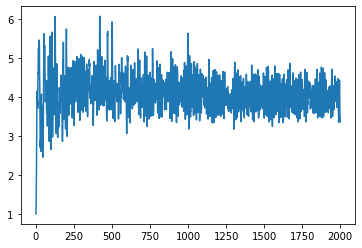

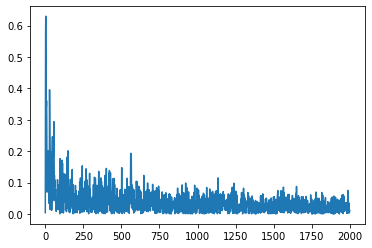

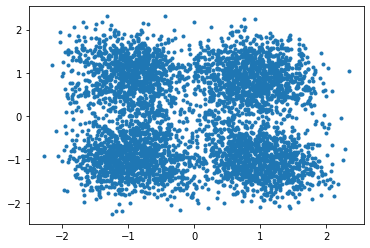

In [ ]:
plt.figure()
plt.plot(w_losses)
plt.savefig('WGANGP_wloss.png')
plt.figure()
plt.plot(losses_D)
plt.savefig('WGANGP_Dloss.png')
xx = base_dist.sample((5000,))
yy = G(xx)
yyy= yy.detach().cpu()
plt.figure()
plt.plot(yyy[:,0],yyy[:,1],'.')
plt.savefig('WGANGP_generatedfigure.png')
wasserstein_loss(xx,yy)


### 2. Train without gradient penalty, vanishing gradient and target distribution not learned

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda')
data_iter = data_generator()
clip_value = 0.1
G = Generator().to(device)
D = Discriminator().to(device)

l2loss = nn.MSELoss()
G = Generator().to(device)
D = Discriminator().to(device)
# print(G)
# print(D)
optim_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.9))
optim_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.9))
loss_G = []
w_losses = []
losses_D = []
for epoch in range(5000):
    # 1. train D first
    for _ in range(5):  # train D 5 times, adjustable
        # 1.1 train on real data
        xr = next(data_iter).float()
        # xr = torch.from_numpy(xr).to(device)
        # [b, 2] => [b, 1]
        predr = D(xr)
        # maximize predr, therefore minus sign
        lossr = -predr.mean()
        # 1.2 train on fake data
        # z=[b, 2]
        z = base_dist.sample((batch_size,))
        xf = G(z).detach()  
        predf = D(xf)
        # min predf
        lossf = predf.mean()
        # aggregate all
        loss_D = lossr + lossf  
        # optimize
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

    # 2. train G
    z = torch.randn(batch_size, 2).to(device)
    xf = G(z)
    predf = D(xf)
    # maximize predf.mean()
    loss_G = -predf.mean() 
    # optimize
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
    w_losses.append(l2loss(z,xf).item())
    losses_D.append(torch.abs(loss_D).item())
    if epoch % 100 == 0:
        print(loss_D.item(), loss_G.item())
        z = torch.randn(batch_size, 2).to(device)
        Y = G(z).detach() 


-0.06047302484512329 -0.491610586643219
4.154636079611862e-10 -6.066733782006395e-10
5.194297422739247e-11 -9.017706720237939e-11
3.303247952946009e-11 -4.741626882798222e-11
2.0324138205740638e-11 -3.001227044663324e-11
1.7536236351922696e-11 -2.268498583424261e-11
1.2326665729811559e-11 -1.700267877879913e-11
1.148254234750734e-11 -1.3171586217552989e-11
9.08105968894235e-12 -1.1477627875899898e-11
7.099136382915372e-12 -1.0926509697029019e-11
7.078132784749114e-12 -9.269733418360016e-12
7.866755857843799e-12 -8.09312946520313e-12
5.48143301581927e-12 -8.360794695461138e-12
5.034317147184497e-12 -8.550679261865035e-12
4.976916448407032e-12 -6.772822754019803e-12
3.938287630039783e-12 -6.999640450588984e-12
2.924284946137501e-12 -6.3347556367165936e-12
3.751492172465731e-12 -5.8669943903133515e-12
2.9369471264695246e-12 -5.216034201782627e-12
3.334047664685369e-12 -5.490145664477364e-12
4.8238132238642706e-12 -4.975032538712121e-12
3.061460807085581e-12 -4.294277607119756e-12
3.255953

tensor(3.7033, device='cuda:0', grad_fn=<MseLossBackward0>)

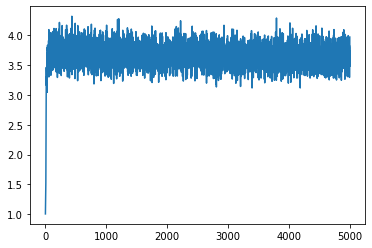

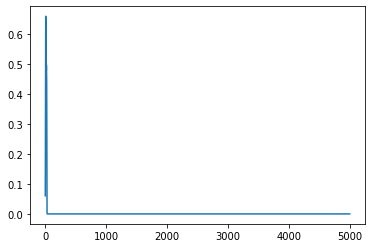

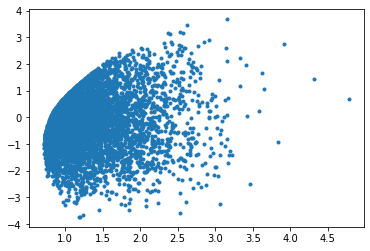

In [ ]:
plt.figure()
plt.plot(w_losses)
plt.savefig('WGAN_noGP_wloss.png')
plt.figure()
plt.plot(losses_D)
plt.savefig('WGAN_noGP_Dloss.png')
xx = base_dist.sample((5000,))
yy = G(xx)
yyy= yy.detach().cpu()
plt.figure()
plt.plot(yyy[:,0],yyy[:,1],'.')
plt.savefig('WGAN_noGP_generatedfigure.png')
wasserstein_loss(xx,yy)


### 3. The SL method, equation (12) in section 3.4 of the paper

target distribution is learned with transport cost around 0.77

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda')
data_iter = data_generator()
clip_value = 0.1
G = Generator().to(device)
D = Discriminator().to(device)

l2loss = nn.MSELoss()
G = Generator().to(device)
D = Discriminator().to(device)
# print(G)
# print(D)
optim_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.9))
optim_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.9))
loss_G = []
w_losses = []
losses_D = []
for epoch in range(5000):
    # 1. train D first
    for _ in range(5):  # train D 5 times, adjustable
        # 1.1 train on real data
        xr = next(data_iter).float()
        # xr = torch.from_numpy(xr).to(device)
        # [b, 2] => [b, 1]
        predr = D(xr)
        # maximize predr, therefore minus sign
        lossr = -predr.mean()
        # 1.2 train on fake data
        # z=[b, 2]
        z = base_dist.sample((batch_size,))
        xf = G(z).detach()  
        predf = D(xf)
        # min predf
        lossf = predf.mean()
        # aggregate all
        loss_D = lossr + lossf  
        # optimize
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

    # 2. train G
    z = torch.randn(batch_size, 2).to(device)
    xf = G(z)
    predf = D(xf)
    # maximize predf.mean()
    loss_G = -predf.mean() + l2loss(z,xf)
    # optimize
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
    w_losses.append(l2loss(z,xf).item())
    losses_D.append(torch.abs(loss_D).item())
    if epoch % 100 == 0:
        print(loss_D.item(), loss_G.item())
        z = torch.randn(batch_size, 2).to(device)
        Y = G(z).detach() 


-0.06047302484512329 0.5137450098991394
-0.03062337636947632 -0.6861428022384644
0.0663486123085022 -0.4139953553676605
-0.026085317134857178 -0.6106919646263123
-0.04438471794128418 -0.48499372601509094
-0.007872603833675385 -0.02211742103099823
3.3893651561811566e-05 0.04946509003639221
-0.00025282916612923145 0.06819853186607361
0.0010125143453478813 0.09228642284870148
0.00011221074964851141 0.07764718681573868
-0.10213220119476318 -0.5564528703689575
-0.0005426621064543724 0.05046319216489792
-0.06082988530397415 -0.16111639142036438
-0.061034321784973145 -0.5562259554862976
0.002387404441833496 -0.7970752716064453
-0.09059959650039673 -0.13962149620056152
0.02904510498046875 -0.5130892395973206
-0.020926952362060547 -0.8181027173995972
-0.021332979202270508 -0.8429707884788513
-0.0003435886465013027 0.06157518923282623
-0.028404951095581055 -0.7873669862747192
-0.0013767480850219727 -0.9323866367340088
-0.011394262313842773 -0.8998172283172607
0.0017997026443481445 -0.84954458475

tensor(0.0772, device='cuda:0', grad_fn=<MseLossBackward0>)

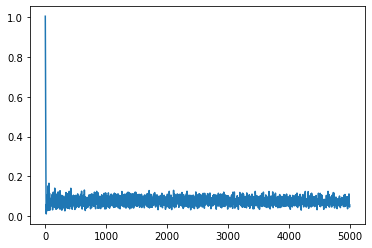

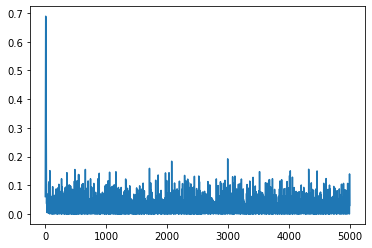

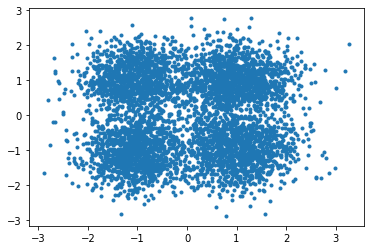

In [ ]:
plt.figure()
plt.plot(w_losses)
plt.savefig('WGAN_SL_wloss.png')
plt.figure()
plt.plot(losses_D)
plt.savefig('WGAN_SL_Dloss.png')
xx = base_dist.sample((5000,))
yy = G(xx)
yyy= yy.detach().cpu()
plt.figure()
plt.plot(yyy[:,0],yyy[:,1],'.')
plt.savefig('WGAN_SL_generatedfigure.png')
wasserstein_loss(xx,yy)


### 4. The AL method, equation (13) in section 3.4 of the paper

target distribution is learned with a transport cost of 

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda')
data_iter = data_generator()
clip_value = 0.1
G = Generator().to(device)
D = Discriminator().to(device)

l2loss = nn.MSELoss()
G = Generator().to(device)
D = Discriminator().to(device)
# print(G)
# print(D)
optim_G = optim.Adam(G.parameters(), lr=5e-4, betas=(0.5, 0.9))
optim_D = optim.Adam(D.parameters(), lr=5e-4, betas=(0.5, 0.9))
loss_G = []
w_losses = []
losses_D = []
rho = 1e-4
for epoch in range(2000):
    # 1. train D first
    for _ in range(5):  # train D 5 times, adjustable
        # 1.1 train on real data
        xr = next(data_iter).float()
        # xr = torch.from_numpy(xr).to(device)
        # [b, 2] => [b, 1]
        predr = D(xr)
        # maximize predr, therefore minus sign
        lossr = -predr.mean()
        # 1.2 train on fake data
        # z=[b, 2]
        z = base_dist.sample((batch_size,))#torch.randn(batch_size, 2).to(device)
        xf = G(z).detach()  # gradient would be passed down
        predf = D(xf)
        # min predf
        lossf = predf.mean()
        # aggregate all
        loss_D = lossr + lossf  
        # optimize
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.param_groups[0]['lr'] = rho 
        optim_D.step()

    # 2. train G
    z = torch.randn(batch_size, 2).to(device)
    xf = G(z)
    predf = D(xf)
    # maximize predf.mean()
    loss_G = -predf.mean() + l2loss(z,xf) + rho/2.*((predf-predr.detach())**2).mean()
    # optimize
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()
    w_losses.append(l2loss(z,xf).item())
    losses_D.append(torch.abs(loss_D).item())
    if epoch % 100 == 0:
        print(loss_D.item(), loss_G.item())
        z = torch.randn(batch_size, 2).to(device)
        Y = G(z).detach() 


-0.029231160879135132 0.5129237174987793
-0.0054978132247924805 -0.44304871559143066
-0.0035382509231567383 -0.4583597183227539
-0.012599647045135498 -0.47137466073036194
-0.0031078457832336426 -0.65352863073349
-0.0005031824111938477 -0.4582711160182953
0.005793154239654541 -0.5087487697601318
-0.009284257888793945 -0.6274896264076233
0.016426026821136475 -0.562866747379303
-0.003788888454437256 -0.5433355569839478
-0.01717960834503174 -0.6130090355873108
-0.020514309406280518 -0.5785264372825623
-0.02044844627380371 -0.5914651155471802
-0.028206825256347656 -0.5373398065567017
-0.0011721253395080566 -0.6282391548156738
-0.02729058265686035 -0.5444560647010803
0.009801626205444336 -0.5919737815856934
0.009980738162994385 -0.5770286917686462
-0.006915092468261719 -0.5528550744056702
-0.00544506311416626 -0.5702987909317017


tensor(0.0707, device='cuda:0', grad_fn=<MseLossBackward0>)

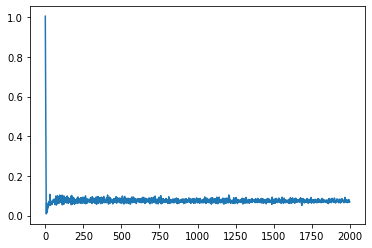

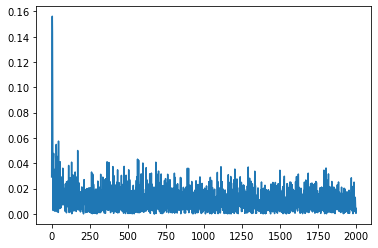

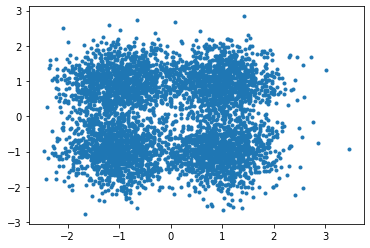

In [ ]:
plt.figure()
plt.plot(w_losses)
plt.savefig('WGAN_AL_wloss.png')
plt.figure()
plt.plot(losses_D)
plt.savefig('WGAN_AL_Dloss.png')
xx = base_dist.sample((5000,))
yy = G(xx)
yyy= yy.detach().cpu()
plt.figure()
plt.plot(yyy[:,0],yyy[:,1],'.')
plt.savefig('WGAN_AL_generatedfigure.png')
wasserstein_loss(xx,yy)


### 5. The ADMM method, described in equation (14) in section 3.4 of the paper.

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda')
data_iter = data_generator()
clip_value = 0.1
G = Generator().to(device)
netG1 = Generator().to(device)
netD1 = Discriminator().to(device)
D = Discriminator().to(device)

l2loss = nn.MSELoss()
# print(G)
# print(D)
optim_G = optim.Adam(G.parameters(), lr=5e-4, betas=(0.5, 0.9))
optim_D = optim.Adam(D.parameters(), lr=5e-4, betas=(0.5, 0.9))
optim_G1 = optim.Adam(netG1.parameters(),lr=5e-4,betas=(0.5,0.9))
optim_D1 = optim.Adam(netD1.parameters(),lr=5e-4,betas=(0.5,0.9))
loss_G = []
w_losses = []
losses_D = []
losses_D1 = []
w_losses1 = []
rho = 1e-5
for epoch in range(2000):
    # 1. train D first
    for _ in range(5):  # train D 5 times, adjustable
        # 1.1 train on real data
        xr = next(data_iter).float()
        # xr = torch.from_numpy(xr).to(device)
        # [b, 2] => [b, 1]
        predr = D(xr)
        # maximize predr, therefore minus sign
        lossr = -predr.mean()
        # 1.2 train on fake data
        # z=[b, 2]
        z = base_dist.sample((batch_size,))#torch.randn(batch_size, 2).to(device)
        xf = G(z).detach()  # gradient would be passed down
        predf = D(xf)
        # min predf
        lossf = predf.mean()
        # 1.3 gradient penalty
        gp = gradient_penalty(D, xr, xf.detach())
        # aggregate all
        loss_D = lossr + lossf  + 0.2 * gp 
        # optimize
        optim_D.zero_grad()
        loss_D.backward()
        optim_D.step()

    # 2. train G
    z = torch.randn(batch_size, 2).to(device)
    xf = G(z)
    xf1 = netG1(z)
    predf = D(xf)
    # maximize predf.mean()
    loss_G = -predf.mean() + torch.mean(netD1(xf)-netD1(xf1).detach()) + rho/2.*((netD1(xf)-netD1(xf1).detach())**2).mean()  #l2loss(z,xf) + torch.mean(netD1(xf)-netD1(xf1).detach()) + rho/2.*((netD1(xf)-netD1(xf1).detach())**2).mean() #-predf.mean() #+ l2loss(z,xf) + rho/2.*((predf-predr.detach())**2).mean()
    # optimize
    optim_G.zero_grad()
    loss_G.backward()
    optim_G.step()

    for _ in range(5):
      loss_D1 = -torch.mean(netD1(xf.detach())-netD1(xf1.detach()))
      optim_D1.zero_grad()
      loss_D1.backward()
      optim_D1.param_groups[0]['lr'] = rho
      optim_D1.step()

    # 3. Train G1
    predf1 = D(xf1)
    loss_G1 = l2loss(z,xf1) + torch.mean(netD1(xf).detach()-netD1(xf1)) + rho/2.*((netD1(xf).detach()-netD1(xf1))**2).mean()  # -predf1.mean() + torch.mean(netD1(xf).detach()-netD1(xf1)) + rho/2.*((netD1(xf).detach()-netD1(xf1))**2).mean() #-predf.mean() #+ l2loss(z,xf) + rho/2.*((predf-predr.detach())**2).mean()
    # optimize
    optim_G1.zero_grad()
    loss_G1.backward()
    optim_G1.step()

    # Train D1

    w_losses.append(l2loss(z,xf).item())
    w_losses1.append(l2loss(z,xf1).item())
    losses_D.append(torch.abs(loss_D).item())
    losses_D1.append(torch.abs(loss_D1).item())
    if epoch % 100 == 0:
        print(loss_D.item(), loss_D.item(),loss_D1.item())
        z = torch.randn(batch_size, 2).to(device)
        Y = G(z).detach()


0.002282366156578064 0.002282366156578064 -9.539537131786346e-06
0.08004263788461685 0.08004263788461685 -0.03428877145051956
0.11462635546922684 0.11462635546922684 0.0374043807387352
-0.032631561160087585 -0.032631561160087585 -0.03860282897949219
0.03103073686361313 0.03103073686361313 -0.04998530074954033
-0.1867501139640808 -0.1867501139640808 0.09894555807113647
-0.10248350352048874 -0.10248350352048874 0.059211235493421555
-0.10603868961334229 -0.10603868961334229 -0.051887303590774536
0.0012691766023635864 0.0012691766023635864 -0.010941137559711933
0.01863083243370056 0.01863083243370056 -0.002011106815189123
-0.05481691285967827 -0.05481691285967827 0.04076530784368515
-0.012719549238681793 -0.012719549238681793 -0.03790070861577988
-0.07901225984096527 -0.07901225984096527 -0.028650712221860886
0.020967133343219757 0.020967133343219757 0.016482995823025703
-0.06815554946660995 -0.06815554946660995 0.026434287428855896
0.07295931875705719 0.07295931875705719 -0.02704908512532

tensor(3.6089, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0491, device='cuda:0', grad_fn=<MseLossBackward0>)


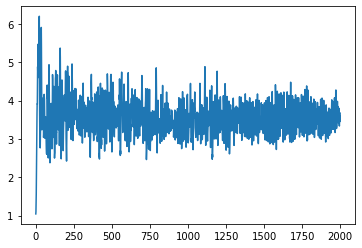

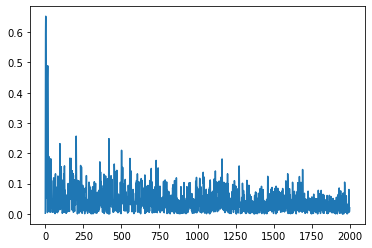

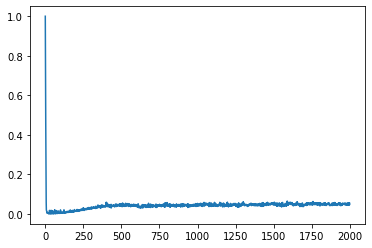

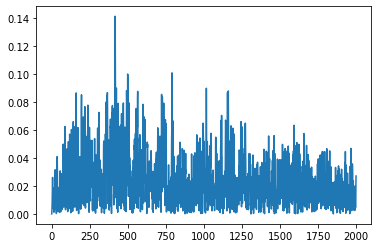

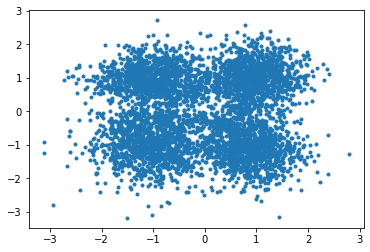

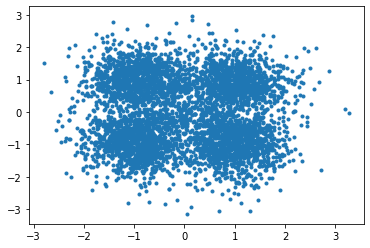

In [ ]:
plt.figure()
plt.plot(w_losses)
plt.savefig('WGAN_ADMM_wloss.png')
plt.figure()
plt.plot(losses_D)
plt.savefig('WGAN_ADMM_Dloss.png')

plt.figure()
plt.plot(w_losses1)
plt.savefig('WGAN_ADMM_wloss1.png')
plt.figure()
plt.plot(losses_D1)
plt.savefig('WGAN_ADMM_Dloss1.png')

xx = base_dist.sample((5000,))
yy = G(xx)
yyy= yy.detach().cpu()
plt.figure()
plt.plot(yyy[:,0],yyy[:,1],'.')
plt.savefig('WGAN_ADMM_generatedfigure.png')
print(wasserstein_loss(xx,yy))

xx = base_dist.sample((5000,))
yy = netG1(xx)
yyy= yy.detach().cpu()
plt.figure()
plt.plot(yyy[:,0],yyy[:,1],'.')
plt.savefig('WGAN_ADMM_generatedfigure1.png')
print(wasserstein_loss(xx,yy))
